In [11]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import janitor 
from math import sqrt

# Modelling 

from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error
import xgboost as xgb
# Carga de datos
df= pd.read_csv("results\df_explorado.csv") 
df.drop('Unnamed: 0', axis =1, inplace=True)
df = janitor.clean_names(df)
df.head()

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jhsga\AppData\Local\Temp\ipykernel_3660\3407484743.py:16: SyntaxWarning: invalid escape sequence '\d'
  df= pd.read_csv("results\df_explorado.csv")


,year,month,hour,pm2_5,dewp,temp,pres,cbwd,iws,is,ir,diadelasemana
0,2010,1,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,Saturday
1,2010,1,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,Saturday
2,2010,1,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,Saturday
3,2010,1,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,Saturday
4,2010,1,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,Saturday


In [16]:
from category_encoders import OneHotEncoder

encoder = OneHotEncoder(cols = ["year", "month", "hour", "cbwd", "diadelasemana"])

# Fit and Optimus prime (transformers)

df_encoded = encoder.fit(df)
df_codificado = df_encoded.transform(df)
df_codificado.shape

(41757, 59)


Evidentemente, el número de columnas se ha aumentado debido a que se han codificado los niveles asociados a cada variable categórica.

# Train-Test Split
Dado que el algoritmo a utilizar (XGBOOST) no requiere escalado de features, se procede a ajustar el modelo tal cual.

In [17]:
df.columns

Index(['year', 'month', 'hour', 'pm2_5', 'dewp', 'temp', 'pres', 'cbwd', 'iws',
       'is', 'ir', 'diadelasemana'],
      dtype='object')

In [18]:
X = df_codificado.drop("pm2_5", axis =1) # matriz de diseño
y = df["pm2_5"]
X = np.array(X)
y = np.array(y)
y = y.reshape(-1,1) # para que pueda volver a verse como un df mas adelante

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.15) # Dejamos de prueba el 15% datos

# modelling
model = xgb.XGBRegressor(objective="reg:squarederror", learning_rate = 0.1, max_depth =30, n_estimators =100)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
resultados = model.score(X_test, y_test)
print("Precision : {}".format(resultados))

Precision : 0.765393386407079


Hasta este punto, el modelo logra una precisión cercana al 76% en el conjunto de prueba. Esto implica que, en general, es un modelo con un desempeño decente.

In [23]:
# realziar predicciones en el conjunto de prueba
y_predict = model.predict(X_test)
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test,
y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)
print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 44.623 
MSE = 1991.2366836410388 
MAE = 26.85495994370407 
R2 = 0.765393386407079 
Adjusted R2 = 0.7632004478755094


En general, estas medidas no dicen mucho por sí solas. La idea es utilizarlas como métricas para compararlas con otros modelos. Sin embargo, noté que el R2 en sí nos proporciona una muy buena explicación de la proporción de la varianza de los datos. Dicho de otra manera, incluso solo fijándose en R2, ya hay buenos indicios para evaluar el rendimiento del modelo, o identificar sobreajuste, en caso de que ocurra.


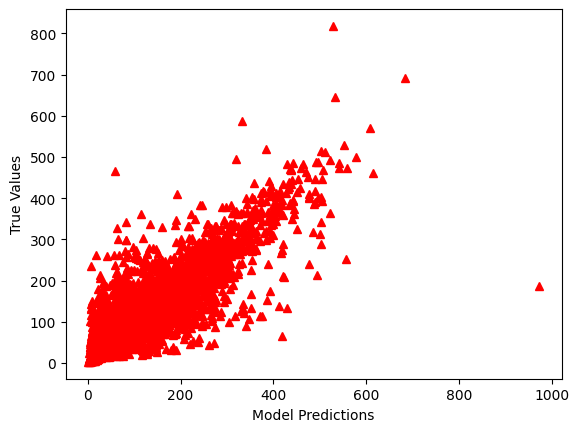

In [24]:
# Plot the scaled result
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')
plt.show()

Este gráfico es una comparativa de los datos predichos versus los valores verdaderos. En un escenario ideal, la predicción perfecta sería una línea recta de 45 grados, donde el modelo predice de manera precisa los valores cercanos a los valores reales. Para este escenario y de manera descriptiva, detectamos una correlación débil entre la respuesta (PM2.5) y el resto de las variables. Aun así, se logra capturar una cantidad no despreciable de la varianza de los datos. Esto se debe a que el algoritmo, optimizado por el descenso del gradiente, realiza una predicción lo suficientemente buena para encontrar algún patrón, como se observa en la acumulación de la nube de puntos en la parte inferior izquierda.

Se reconoce que este algoritmo debe tener una serie de hiperparámetros a calibrar que, por cuestiones de tiempo, no se han podido realizar. Sin embargo, se podría optimizar ligeramente este algoritmo de tal manera que la precisión del modelo aumente.

# Comentarios finales

Se realizó un análisis basado en técnicas de regresión, ya que se tiene certeza de que XGBOOST está optimizado para este tipo de problemas; sin embargo, desde el análisis descriptivo se ha dejado entrever que, desde un análisis temporal vía series de tiempo, quizás también sea una opción viable.

Se descartó la implementación de otros modelos por una cuestión de tiempo, ya que, entre otras cosas, se tuvieron dificultades para presentar la prueba.

Relacionado con esto último, me disculpo, ya que el equipo de cómputo donde suelo trabajar sufrió un daño y hasta el momento no ha sido posible recuperarlo. Para presentar esta prueba, tuve que realizar dicho ejercicio en la madrugada del viernes, ya que fue el único espacio donde pude conseguir cómo resolverlo.

Aun así, agradezco la oportunidad que se me otorgó dentro del proceso y reconozco que desde mis capacidades se pudo haber hecho más y mejor. Pero esta vez no ha sido posible. Muchas gracias y espero tener noticias pronto.

Jhonatan Smith García Muñoz
Estadístico